In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

# Create timestamps
time = np.arange(0, 50, 0.1) 

# Assign Amplitude and normalize above 0
amplitude = np.sin(time)      # 1. Generate the sine wave: Values will range from -1 to +1
amplitude = amplitude + 1     # 2. Shift values above zero: Add 1 to make the range 0 to 2
max_amp = max(amplitude)    # 3. Find the maximum amplitude: This will be 2 (after the shift)
amplitude = amplitude / max_amp # 4. Normalize to a range of 0 to 1: Divide by max_amp 
                                 #    so the sine wave values now fluctuate between 0 and 1.

# Construct DataFrame using Polars
df = pl.DataFrame({
    "Close": amplitude  # Using capital "C" for consistency 
})

# Calculate percentage change 
df = df.with_columns(
    pl.col("Close").pct_change().alias("Close_Rt")  # Capital "R" for consistency
)


df = df.fill_nan(None)

# Show DataFrame and Values
print(f"Length: {len(df)}")
print(f"Min Close: {df['Close'].min()}")
print(f"Max Close: {df['Close'].max()}")
print("\nDataFrame Head:")
print(df.head()) 


Length: 500
Min Close: 4.896739968063352e-06
Max Close: 1.0

DataFrame Head:
shape: (5, 2)
┌──────────┬──────────┐
│ Close    ┆ Close_Rt │
│ ---      ┆ ---      │
│ f64      ┆ f64      │
╞══════════╪══════════╡
│ 0.500002 ┆ null     │
│ 0.549918 ┆ 0.099833 │
│ 0.599337 ┆ 0.089864 │
│ 0.647762 ┆ 0.080799 │
│ 0.694711 ┆ 0.072479 │
└──────────┴──────────┘


In [2]:
df = df.fill_null(0)
df.head()

Close,Close_Rt
f64,f64
0.500002,0.0
0.549918,0.099833
0.599337,0.089864
0.647762,0.080799
0.694711,0.072479


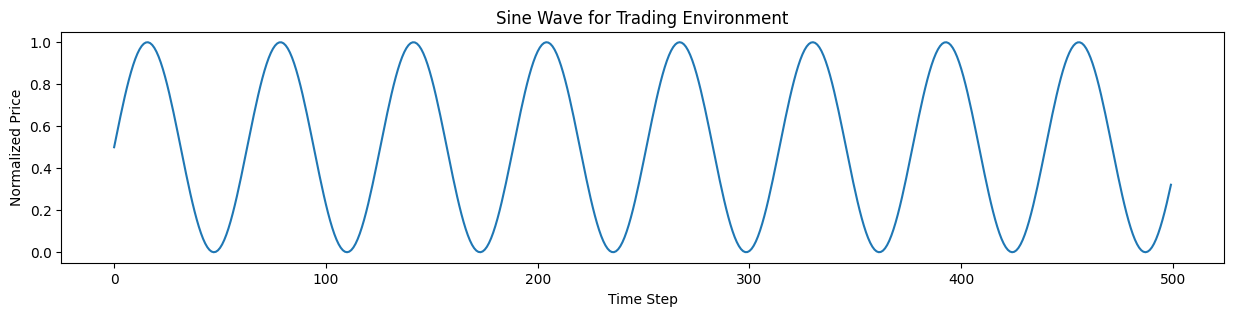

In [3]:
# Plot the sine wave (Matplotlib works well with Polars)
plt.rcParams['figure.figsize'] = (15, 3)  # Set plot size
plt.plot(df['Close']) 
plt.title("Sine Wave for Trading Environment")
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.show()


In [4]:
import gym
from gym import spaces  # Use Gym 0.24.0 from pip install
import numpy as np
import polars as pl # use polars
import random
import torch

In [6]:
# Initialize variables
MAX_INT = 2147483647
MAX_OPEN_POSITIONS = 1  # Maximum number of simultaneous open positions allowed
INITIAL_ACCOUNT_BALANCE = 1000  # Starting capital for trading
PERCENT_CAPITAL = 0.1  # Percentage of capital to be used for each trade
TRADING_COSTS_RATE = 0.001  # Trading cost percentage per trade
KILL_THRESH = 0.4  # Threshold for balance preservation (if net_worth falls below this, trading stops)


# Structure environment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df: pl.DataFrame): # make sure we have a polars dataframe as input
        super(StockTradingEnv, self).__init__()

        # Generic variables
        self.df = df  # DataFrame containing historical price data

        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE  # Tracks available capital
        self.net_worth = INITIAL_ACCOUNT_BALANCE  # Total account value
        self.realized_profit = 0  # Profit from closed positions
        self.unrealized_profit = 0  # Profit from open positions (unrealized)
        self.last_profit = 0  # Profit from the most recent closed position

        # Position variables
        self.open_quantities = []  # List to store quantities of assets in open positions
        self.open_prices = []  # List to store prices at which positions were opened
        self.trading_costs = 0  # Total trading costs incurred
        self.open_positions = 0  # Number of currently open positions
        self.closed_positions = 0  # Number of positions closed
        self.incorrect_position_calls = 0  # Number of times an invalid trading action was attempted
        self.num_trades = 0  # Total number of trades executed
        self.held_for_period = 0  # Number of steps a position has been held

        # Current Step
        self.current_step = 0  # Current time step in the trading environment
        self.max_steps = len(df)  # Total number of time steps in the dataset

        # Actions of the format Long, Hold, Close
        self.action_space = spaces.Discrete(3)  # 0: Long, 1: Hold, 2: Close

        # Prices contains the Close and Close Returns etc
        self.observation_space = spaces.Box(low=-1, high=1, shape=(8,),
                                            dtype=np.float32)  # Observation space shape (8 features)

    # Calculate Reward
    def _calculate_reward(self):
        """Calculates the reward for taking an action at the current step."""
        reward = 0  # Initialize reward

        # Reward for profit only if trades have been made
        if self.num_trades:
            reward += self.realized_profit / self.num_trades  # Reward for average realized profit
            reward += self.unrealized_profit / self.num_trades * 0.3  # Reward for unrealized profit (smaller weight)
            reward += 1 if self.last_profit > 0 else 0  # Bonus for a profitable last trade

        reward -= 1 if self.incorrect_position_calls > 0 else 0  # Penalty for incorrect position calls

        # Additional penalty if the reward is non-positive
        if reward <= 0:
            reward -= 2
        return reward

    # Structure sign observation data
    def _next_observation(self):
        """Returns the next observation (state) of the environment."""
        # Accessing polars dataframe by index is slightly different than pandas
        close_item = self.df["Close"][self.current_step]
        close_rt_item = self.df["Close_Rt"][self.current_step]
        close_T1_item = self.df["Close_Rt"][self.current_step - 1] if (
                    self.current_step - 1) >= 0 else 0  # Lookback: 1 step
        close_T2_item = self.df["Close_Rt"][self.current_step - 2] if (
                    self.current_step - 2) >= 0 else 0  # Lookback: 2 steps
        close_T3_item = self.df["Close_Rt"][self.current_step - 3] if (
                    self.current_step - 3) >= 0 else 0  # Lookback: 3 steps
        close_T4_item = self.df["Close_Rt"][self.current_step - 4] if (
                    self.current_step - 4) >= 0 else 0  # Lookback: 4 steps

        current_position = 1 if self.open_positions else 0  # 1 if a position is open, else 0
        num_trades = self.num_trades / len(self.df) if self.num_trades > 0 else 0  # Normalize number of trades

        # Create the observation array
        obs = np.array([close_item, close_rt_item, close_T1_item, close_T2_item, close_T3_item, close_T4_item,
                        current_position, num_trades])
        return obs

    # Calculate current open value
    def _calculate_open_value(self):
        """Calculates the total value of all open positions."""
        open_trades_value = 0
        counts = 0
        for qty in self.open_quantities:
            acquisition_price = self.open_prices[counts]
            open_trades_value += acquisition_price * qty
            counts += 1
        return open_trades_value

    # Calculate gross profit
    def _profit_calculation(self, current_price, calc_type):
        """Calculates profit based on the current price and action type."""
        open_trades_value = self._calculate_open_value()  # Get current value of open positions
        total_quantity_held = sum(self.open_quantities)  # Total quantity of assets held
        current_value = total_quantity_held * current_price  # Value if all positions were closed now

        # Calculate gross profit
        gross_profit = current_value - open_trades_value

        # Calculate trading costs based on action type
        if calc_type == "close_position":
            trading_costs = current_value * TRADING_COSTS_RATE  # Costs when closing positions
            self.trading_costs += trading_costs  # Update total trading costs
        elif calc_type == "hold_position" or calc_type == "open_position":
            trading_costs = open_trades_value * TRADING_COSTS_RATE  # Costs when holding or opening

        net_profit = gross_profit - trading_costs  # Calculate net profit
        return net_profit

    # Set the current price to a random price within the time step
    def _take_action(self, action):
        """Executes the chosen action in the trading environment."""
        current_price = self.df["Close"][self.current_step]  # Get current price

        # Reset temporary variables
        self.last_profit = 0
        self.incorrect_position_calls = 0

        # ------------------------------------------------------------------
        # Trading Logic based on Action
        # ------------------------------------------------------------------
        # Go Long (Buy)
        if action == 0:
            if self.open_positions < MAX_OPEN_POSITIONS:  # Check if allowed to open more positions
                net_profit = self._profit_calculation(current_price,
                                                      "open_position")  # Calculate potential profit
                net_worth = self.net_worth + net_profit
                trading_allowance = net_worth * PERCENT_CAPITAL  # Calculate the amount to invest

                # Update position information
                self.open_quantities.append(trading_allowance / current_price)  # Quantity purchased
                self.open_prices.append(current_price)  # Price at purchase
                self.trading_costs += trading_allowance * TRADING_COSTS_RATE  # Add trading costs
                self.num_trades += 1  # Increment trade counter
            else:
                self.incorrect_position_calls += 1  # Penalize for trying to exceed open position limit

        # Hold Positions
        if action == 1:
            net_profit = self._profit_calculation(current_price,
                                                      "hold_position")  # Calculate profit/loss for holding
            self.unrealized_profit += net_profit  # Update unrealized profit
            if self.open_positions > 0:
                self.held_for_period += 1  # Increment hold period counter

        # Close Positions (Sell)
        if action == 2:
            if self.open_positions != 0:  # Check if there are positions to close
                net_profit = self._profit_calculation(current_price, "close_position")  # Calculate closing profit
                self.last_profit = net_profit  # Update last profit
                self.realized_profit += net_profit  # Update realized profit

                # Reset position-related variables as all positions are closed
                self.unrealized_profit = 0
                self.open_quantities = []
                self.open_prices = []
                self.held_for_period = 0
                self.closed_positions += 1  # Increment closed positions counter
            else:
                self.incorrect_position_calls += 1  # Penalize for trying to close when no positions are open
        # ------------------------------------------------------------------

        # Update account variables
        open_trades_value = self._calculate_open_value()
        self.open_positions = len(self.open_quantities)
        self.net_worth = INITIAL_ACCOUNT_BALANCE + self.unrealized_profit + self.realized_profit
        self.available_balance = INITIAL_ACCOUNT_BALANCE - open_trades_value + self.realized_profit

    # Execute one time step within the environment
    def step(self, action):
        """Performs a single step in the environment."""
        self._take_action(action)  # Execute the chosen action

        reward = self._calculate_reward()  # Calculate the reward for the action

        self.current_step += 1  # Move to the next time step

        # Check termination conditions
        is_max_steps_taken = self.current_step >= self.max_steps - 1  # Reached maximum steps
        is_account_balance_reached = self.net_worth <= INITIAL_ACCOUNT_BALANCE * KILL_THRESH  # Account below threshold
        done = True if is_max_steps_taken or is_account_balance_reached else False  # Set 'done' flag if terminated

        obs = self._next_observation()  # Get the next observation

        return obs, reward, done, {}  # Return observation, reward, done flag, and additional info (empty dict)

    # Reset the state of the environment to an initial state
    def reset(self):
        """Resets the environment to its initial state."""
        self.account_balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.realized_profit = 0
        self.unrealized_profit = 0
        self.open_quantities = []
        self.open_prices = []
        self.trading_costs = 0
        self.open_positions = 0
        self.incorrect_position_calls = 0
        self.current_step = 5  # Start from the 6th step to have enough lookback data

        return self._next_observation()  # Return the initial observation

    # Render the environment to the screen
    def render(self, mode='human', close=False):
        """Renders the environment (not implemented in this example)."""
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
        return profit

In [7]:
# Test Environment
env = StockTradingEnv(df)
actions = [0, 1, 2] # 0 long, 1 hold, 2 close position sell
observation = env.reset()
print("Initial Observation: ", observation)

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received : ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Net Worth : ", env.net_worth)
    print("Realized Profit: ", env.realized_profit)
    print("Unrealized Profit: ", env.unrealized_profit)
    print("Open Quantities: ", env.open_quantities)
    print("Open Prices: ", env.open_prices)
    print("Trading Costs: ", env.trading_costs)
    print("Open Positions: ", env.open_positions)
    print("Incorrect Calls: ", env.incorrect_position_calls)
    print("-------------------")

Initial Observation:  [0.73971508 0.06478049 0.0724791  0.08079866 0.08986444 0.09983342
 0.         0.        ]

Action Taken:  0
Reward Received :  -2.0
Next State:  [0.78232368 0.05760137 0.06478049 0.0724791  0.08079866 0.08986444
 1.         0.002     ]
Completed:  False
-------------------
Available Balance:  900.0
Net Worth :  1000
Realized Profit:  0
Unrealized Profit:  0
Open Quantities:  [135.18718520595226]
Open Prices:  [0.7397150835536224]
Trading Costs:  0.1
Open Positions:  1
Incorrect Calls:  0
-------------------

Action Taken:  1
Reward Received :  1.6980410382376971
Next State:  [0.82211142 0.0508584  0.05760137 0.06478049 0.0724791  0.08079866
 1.         0.002     ]
Completed:  False
-------------------
Available Balance:  900.0
Net Worth :  1005.6601367941256
Realized Profit:  0
Unrealized Profit:  5.660136794125657
Open Quantities:  [135.18718520595226]
Open Prices:  [0.7397150835536224]
Trading Costs:  0.1
Open Positions:  1
Incorrect Calls:  0
-----------------

### Utilities

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    """
    Plots the learning curve of an agent during training, showing the running average of scores.

    Args:
        x (array-like): An array representing the x-axis values (e.g., episodes or steps).
        scores (array-like): An array of scores achieved by the agent at each x-axis value.
        figure_file (str): The filename to save the plot to.
    """
    
    running_avg = np.zeros(len(scores))  # Initialize an array to store the running average
    
    # Calculate running average over a window of 100 scores
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])  # Calculate mean of scores for the current window
    
    # Plot the running average
    plt.plot(x, running_avg)  # Plot x-values against the running average
    plt.title('Running average of previous 100 scores')  # Set plot title
    plt.savefig(figure_file)  # Save the plot to a file 

### PPO Classes

#### Imports

In [9]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

#### PPO Memory Management

In [10]:
import numpy as np
from typing import List, Tuple, Any

class PPOMemory:
    """
    Experience replay buffer for Proximal Policy Optimization (PPO).

    This class stores and manages the agent's experiences (state, action, reward, etc.) 
    collected during training. It provides methods to sample batches of these 
    experiences for efficient learning. It uses NumPy arrays for efficient storage 
    and operations, and implements a circular buffer to manage memory.
    """

    def __init__(self, batch_size: int, state_dim: int, max_size: int = 10000):
        """
        Initializes the PPOMemory buffer.

        Args:
            batch_size (int): The size of each batch sampled from the buffer.
            state_dim (int): The dimensionality of the state space.
            max_size (int, optional): Maximum number of experiences to store. Defaults to 10000.
        """
        self.batch_size = batch_size
        self.max_size = max_size
        self.ptr = 0  # Pointer to keep track of the current position in the buffer

        # Initialize memory arrays using NumPy for efficient storage and operations
        self.states = np.zeros((max_size, state_dim), dtype=np.float32)   # Store states
        self.actions = np.zeros(max_size, dtype=np.int32)                # Store actions taken
        self.probs = np.zeros(max_size, dtype=np.float32)                 # Store action probabilities
        self.vals = np.zeros(max_size, dtype=np.float32)                  # Store state values (critic estimates)
        self.rewards = np.zeros(max_size, dtype=np.float32)                # Store rewards received
        self.dones = np.zeros(max_size, dtype=bool)                     # Store done flags (episode termination)

    def store_memory(self, state: np.ndarray, action: int, probs: float, vals: float, reward: float, done: bool) -> None:
        """
        Stores a single experience tuple in the buffer.

        Args:
            state (np.ndarray): The current state.
            action (int): The action taken.
            probs (float): The probability of taking the chosen action.
            vals (float): The estimated value of the current state.
            reward (float): The reward received after taking the action.
            done (bool): True if the episode ended after this step, False otherwise.
        """
        idx = self.ptr % self.max_size  # Calculate index using modulo for circular buffer
        
        # Store experience at the calculated index
        self.states[idx] = state
        self.actions[idx] = action
        self.probs[idx] = probs
        self.vals[idx] = vals
        self.rewards[idx] = reward
        self.dones[idx] = done
        
        self.ptr += 1  # Increment pointer for the next experience

    def generate_batches(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[np.ndarray]]:
        """
        Generates random batches of experiences for training.

        This method shuffles the stored experiences and then creates batches of 
        indices pointing to those shuffled experiences. It uses memory views to avoid
        copying data, which is more efficient than creating new arrays.

        Returns:
            Tuple[np.ndarray, ...]: A tuple containing:
                - states (np.ndarray): Batch of states.
                - actions (np.ndarray): Batch of actions.
                - probs (np.ndarray): Batch of action probabilities.
                - vals (np.ndarray): Batch of state values.
                - rewards (np.ndarray): Batch of rewards.
                - dones (np.ndarray): Batch of done flags.
                - batches (List[np.ndarray]): A list of arrays, each containing indices for a batch of experiences.
        """
        max_mem = min(self.ptr, self.max_size)  # Use stored memory up to max_size
        indices = np.random.permutation(max_mem)  # Shuffle indices to create random batches

        # Get memory views (references, not copies) for efficiency
        states = self.states[:max_mem]
        actions = self.actions[:max_mem]
        probs = self.probs[:max_mem]
        vals = self.vals[:max_mem]
        rewards = self.rewards[:max_mem]
        dones = self.dones[:max_mem]

        # Create batch starting indices
        start_idx = np.arange(0, max_mem, self.batch_size) 

        # Generate batches of indices
        batches = [indices[i:i+self.batch_size] for i in start_idx]  

        return (states, actions, probs, vals, rewards, dones, batches)

    def clear_memory(self) -> None:
        """Clears the replay buffer."""
        self.ptr = 0  # Reset the pointer to the beginning

#### Create a tmp Directory

## Actor Neural Net

In [11]:
# Actor Neural Network

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
                 fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()

        # Ensure the checkpoint directory exists
        os.makedirs(chkpt_dir, exist_ok=True)
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo_sine')
        
        self.actor = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
            nn.Softmax(dim=-1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Convert numpy array to torch tensor if necessary
        if isinstance(state, np.ndarray):
            state = T.tensor(state, dtype=T.float).to(self.device)
        
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))


### Critic Neural Net

In [12]:
# Critic Neural Net

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
                 chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()

        # Ensure the checkpoint directory exists
        os.makedirs(chkpt_dir, exist_ok=True)

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo_sine')
        self.critic = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Convert numpy array to torch tensor if necessary
        if isinstance(state, np.ndarray):
            state = T.tensor(state, dtype=T.float).to(self.device)
        
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))


### Agent 

It manages the interaction between the environment and the learning process. 

1. Maintains an actor network to decide actions and a critic network to estimate state values.
2. Chooses actions based on the current policy when given an observation from the environment.
3. Stores experiences (state, action, reward, etc.) in a memory buffer.
4. Periodically learns from collected experiences by updating its policy and value estimates.
5. Uses GAE (Generalized Advantage Estimation) to compute advantages, which helps balance bias and variance in policy updates.
6. Implements the PPO objective, which allows for stable policy improvements while preventing too large policy changes.
7. Provides methods to save and load trained models for continued learning or deployment.

In [13]:
# Agent Neural Net

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
                 policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma  # Discount factor for future rewards
        self.policy_clip = policy_clip  # Clipping parameter for PPO
        self.n_epochs = n_epochs  # Number of epochs to train on each batch
        self.gae_lambda = gae_lambda  # Lambda parameter for Generalized Advantage Estimation
    
        # Initialize actor and critic networks
        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size, input_dims)  # Pass input_dims to PPOMemory
       
    def remember(self, state, action, probs, vals, reward, done):
        # Store experience in memory buffer
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        # Save actor and critic models
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        # Load actor and critic models
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        # Convert observation to tensor and choose action
        state = T.tensor(observation, dtype=T.float).to(self.actor.device)
        
        # Get action distribution and state value
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        # Extract probabilities, action, and value
        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            # Generate batches from memory
            state_arr, action_arr, old_prob_arr, vals_arr, \
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            # Calculate advantages using GAE
            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t

            # Convert to tensors
            advantage = T.tensor(advantage).to(self.actor.device)
            values = T.tensor(values).to(self.actor.device)

            # Update policy and value function
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                # Get new action distributions and critic values
                dist = self.actor(states)
                critic_value = self.critic(states)
                critic_value = T.squeeze(critic_value)

                # Calculate ratios for PPO update
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()

                # Compute PPO loss
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                # Compute critic loss
                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                # Compute total loss and perform backpropagation
                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        # Clear memory after learning
        self.memory.clear_memory()


In [14]:
import logging
from typing import Dict, Any

# Configuration
CONFIG: Dict[str, Any] = {
    'batch_size': 5,
    'n_epochs': 4,
    'alpha': 0.0003,
    'test_episodes': 1
}

# Set up logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Remove all handlers associated with the logger object.
for handler in logger.handlers[:]:
    logger.removeHandler(handler)

# Create file handler
file_handler = logging.FileHandler('trading_agent.log', mode='w')
file_handler.setLevel(logging.INFO)

# Create console handler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

# Rest of your code remains the same...

# Testing
try:
    # Create the trading environment
    env = StockTradingEnv(df)

    # Initialize the agent
    agent = Agent(n_actions=env.action_space.n, batch_size=CONFIG['batch_size'], 
                  alpha=CONFIG['alpha'], n_epochs=CONFIG['n_epochs'], 
                  input_dims=env.observation_space.shape[0])

    episode_data = []  # List to store data for visualization

    for episode in range(CONFIG['test_episodes']):
        # Reset the environment and get initial observation
        observation = env.reset()

        # Choose an action using the agent
        action, prob, val = agent.choose_action(observation)

        # Get the number of possible actions
        n_actions = env.action_space.n

        # Log initial state and action information
        logger.info(f"Episode {episode + 1}")
        logger.info(f"Initial Observation: {observation}")
        logger.info(f"Number of Actions: {n_actions}")
        logger.info(f"Action Chosen: {action}")
        logger.info(f"Probability of Action: {prob}")
        logger.info(f"Value of Action: {val}")

        # Take a step in the environment
        try:
            observation_, reward, done, info = env.step(action)
        except Exception as e:
            logger.error(f"Error during environment step: {str(e)}")
            break

        # Log the results of the step
        logger.info(f"Next Observation: {observation_}")
        logger.info(f"Reward: {reward}")
        logger.info(f"Done: {done}")
        logger.info(f"Info: {info}")

        # Store the experience
        agent.remember(observation, action, prob, val, reward, done)

        # Store data for visualization
        episode_data.append({
            'episode': episode + 1,
            'initial_observation': observation,
            'action': action,
            'reward': reward
        })

except Exception as e:
    logger.error(f"An error occurred during testing: {str(e)}")

finally:
    logger.info("Testing completed")

2024-08-06 17:12:55,508 - __main__ - INFO - Episode 1
2024-08-06 17:12:55,509 - __main__ - INFO - Initial Observation: [0.73971508 0.06478049 0.0724791  0.08079866 0.08986444 0.09983342
 0.         0.        ]
2024-08-06 17:12:55,509 - __main__ - INFO - Number of Actions: 3
2024-08-06 17:12:55,509 - __main__ - INFO - Action Chosen: 1
2024-08-06 17:12:55,509 - __main__ - INFO - Probability of Action: -1.0197747945785522
2024-08-06 17:12:55,510 - __main__ - INFO - Value of Action: -0.053888868540525436
2024-08-06 17:12:55,510 - __main__ - INFO - Next Observation: [0.78232368 0.05760137 0.06478049 0.0724791  0.08079866 0.08986444
 0.         0.        ]
2024-08-06 17:12:55,510 - __main__ - INFO - Reward: -2
2024-08-06 17:12:55,510 - __main__ - INFO - Done: False
2024-08-06 17:12:55,511 - __main__ - INFO - Info: {}
2024-08-06 17:12:55,511 - __main__ - INFO - Testing completed


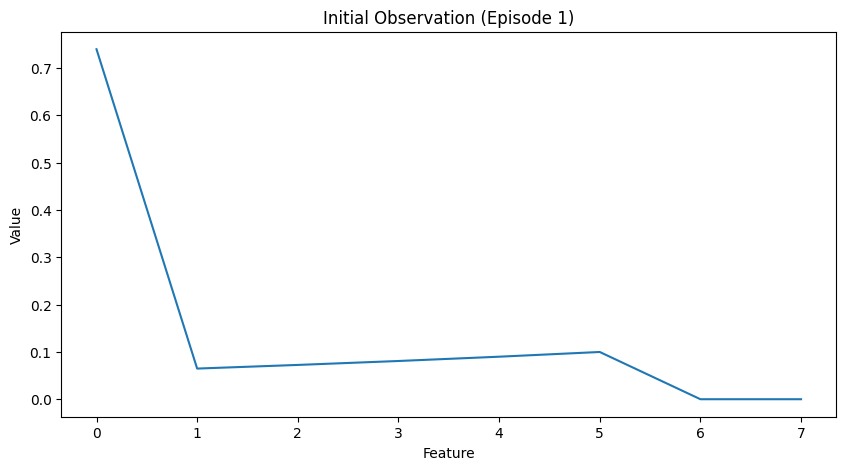

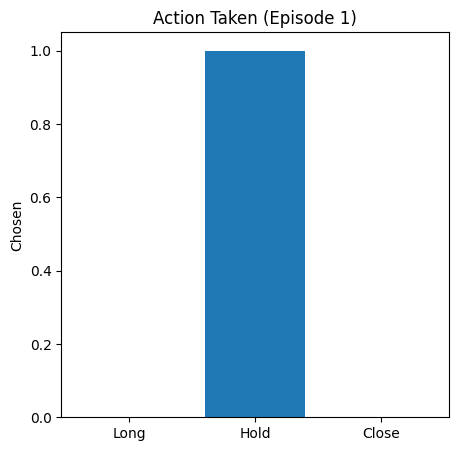

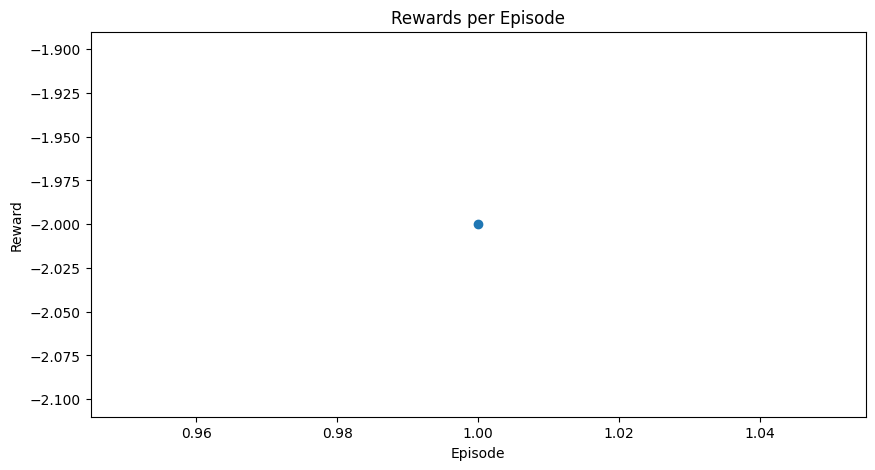

In [15]:
import matplotlib.pyplot as plt

# Visualization
if episode_data:
    for data in episode_data:
        # Visualize initial state
        plt.figure(figsize=(10, 5))
        plt.plot(data['initial_observation'])
        plt.title(f"Initial Observation (Episode {data['episode']})")
        plt.xlabel("Feature")
        plt.ylabel("Value")
        plt.show()

        # Visualize action taken
        plt.figure(figsize=(5, 5))
        plt.bar(['Long', 'Hold', 'Close'], [1 if i == data['action'] else 0 for i in range(3)])
        plt.title(f"Action Taken (Episode {data['episode']})")
        plt.ylabel("Chosen")
        plt.show()

    # Plot rewards
    plt.figure(figsize=(10, 5))
    plt.plot([data['episode'] for data in episode_data], [data['reward'] for data in episode_data], marker='o')
    plt.title("Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
else:
    print("No episode data available for visualization.")

### Train Agents

... starting ...
episode: 0, score: 17449886.060276218, avg score: 17449886.060276218, time_steps: 494, learning steps: 24
episode: 1, score: 1374551.7167204272, avg score: 9412218.888498323, time_steps: 988, learning steps: 49
episode: 2, score: 109768.497070067, avg score: 6311402.091355571, time_steps: 1482, learning steps: 74
episode: 3, score: 431525.59303445125, avg score: 4841432.966775291, time_steps: 1976, learning steps: 98
episode: 4, score: 469587.92193212605, avg score: 3967063.957806658, time_steps: 2470, learning steps: 123
episode: 5, score: 6964274.438151383, avg score: 4466599.037864112, time_steps: 2964, learning steps: 148
episode: 6, score: 33580.01397917262, avg score: 3833310.6058805496, time_steps: 3458, learning steps: 172
episode: 7, score: 22316.679464314395, avg score: 3356936.36507852, time_steps: 3952, learning steps: 197
episode: 8, score: 15491.77399956388, avg score: 2985664.7438475247, time_steps: 4446, learning steps: 222
episode: 9, score: 8995.09081

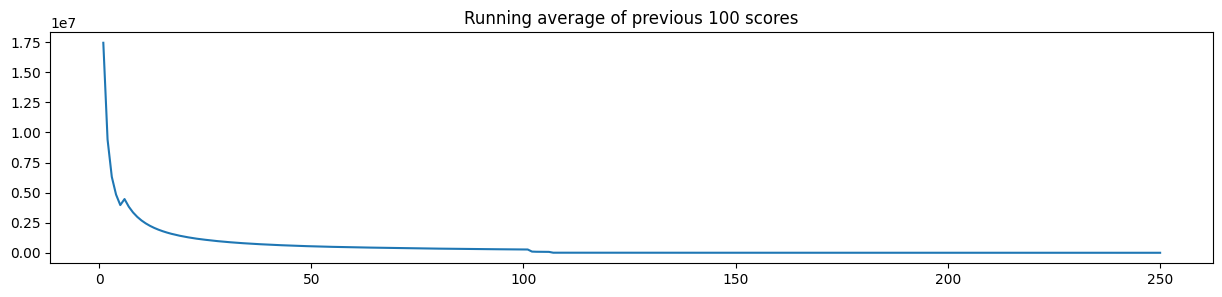

In [16]:


if __name__ == '__main__':
    # Assuming df is already defined and contains your sine wave data
    env = StockTradingEnv(df)
    N = 20
    batch_size = 5
    n_epochs = 8
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape[0])  # Note the change here
    n_games = 250

    figure_file = 'sinewave.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0
    
    print("... starting ...")
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
            
        # Save history
        score_history.append(score)
        avg_score = np.mean(score_history[-50:])
        
        if avg_score > best_score and i > 50:
            best_score = avg_score
            agent.save_models()
            
        print(f"episode: {i}, score: {score}, avg score: {avg_score}, time_steps: {n_steps}, learning steps: {learn_iters}")
            
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

### Load Model

In [17]:
# Get the number of actions and input dimensions
n_actions = env.action_space.n
input_dims = env.observation_space.shape[0]  # Note: We use [0] to get the scalar value

# Set the learning rate
alpha = 0.0003

# Create the ActorNetwork model
model = ActorNetwork(n_actions, input_dims, alpha)

# Load the saved model state
model.load_state_dict(T.load("tmp/actor_torch_ppo_sine"))

# Set the model to evaluation mode
model.eval()

ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3, bias=True)
    (5): Softmax(dim=-1)
  )
)

### Get Results

In [18]:
# Initialize lists to store probabilities for each action
open_probs = []
hold_probs = []
close_probs = []
actions = []

# Initialize trading state variables
is_open = 0  # Indicates if a position is currently open
num_trades = 0  # Total number of trades made
held_for = 0  # Number of steps a position has been held
num_trades_perc = 0  # Percentage of total steps where trades have been made

# Iterate through the DataFrame, starting from the 5th row to have enough lookback data
for step in range(5, len(df)):
    # Extract relevant features from the DataFrame
    close_item = df["Close"][step]
    close_rt_item = df["Close_Rt"][step]
    close_T1_item = df["Close_Rt"][step - 1]
    close_T2_item = df["Close_Rt"][step - 2]
    close_T3_item = df["Close_Rt"][step - 3]
    close_T4_item = df["Close_Rt"][step - 4]
    
    # Create the state vector
    state = np.array([close_item, close_rt_item, close_T1_item, close_T2_item, close_T3_item, close_T4_item, 
                      is_open, num_trades_perc])
    
    # Convert state to PyTorch tensor
    state = T.tensor(state, dtype=T.float).to(model.device)
    
    # Get action probabilities from the model
    dist = model(state)
    probs = dist.probs.detach().cpu().numpy()
    
    print(probs)  # Print probabilities for debugging
    
    # Determine the action (assuming the action with highest probability is chosen)
    action = np.argmax(probs)
    
    # Update trading state based on the action
    if action == 0:  # Open position
        is_open = 1
        num_trades += 1
        num_trades_perc = num_trades / len(df)
    elif action == 1 and is_open:  # Hold position
        held_for += 1
    elif action == 2:  # Close position
        is_open = 0
        held_for = 0

    # Store probabilities for each action
    open_probs.append(probs[0])
    hold_probs.append(probs[1])
    close_probs.append(probs[2])

# Print the number of steps processed
print(len(open_probs))

[0.00132967 0.06218687 0.9364835 ]
[0.00105679 0.06103624 0.937907  ]
[8.4984617e-04 5.9782058e-02 9.3936813e-01]
[6.9506321e-04 5.9067808e-02 9.4023716e-01]
[5.8042892e-04 5.8551431e-02 9.4086814e-01]
[4.9408211e-04 5.8230873e-02 9.4127506e-01]
[4.3017909e-04 5.8216527e-02 9.4135332e-01]
[3.8230172e-04 5.8514427e-02 9.4110328e-01]
[3.4648404e-04 5.9143312e-02 9.4051021e-01]
[3.2075349e-04 6.0102414e-02 9.3957686e-01]
[3.0286008e-04 6.1459683e-02 9.3823743e-01]
[2.9167332e-04 6.3259341e-02 9.3644899e-01]
[2.8646013e-04 6.5565154e-02 9.3414843e-01]
[2.8680573e-04 6.8434894e-02 9.3127835e-01]
[2.9244518e-04 7.1890965e-02 9.2781663e-01]
[3.0285981e-04 7.6046176e-02 9.2365098e-01]
[3.1867213e-04 8.0993079e-02 9.1868830e-01]
[3.3993396e-04 8.7791562e-02 9.1186851e-01]
[3.6730204e-04 9.5868066e-02 9.0376467e-01]
[4.0209005e-04 1.0496613e-01 8.9463180e-01]
[4.4508517e-04 1.1480365e-01 8.8475126e-01]
[4.9823220e-04 1.2593679e-01 8.7356502e-01]
[5.6266895e-04 1.3886850e-01 8.6056882e-01]
[6.386

In [19]:
# Purpose: Add action probabilities to the DataFrame for analysis

# Create a copy of the original DataFrame
df_new = df.clone()

# Remove the first 5 rows to align with our trading simulation
df_new = df_new.slice(offset=5)

# Add new columns for the action probabilities
df_new = df_new.with_columns([
    pl.Series("Opens", open_probs),
    pl.Series("Holds", hold_probs),
    pl.Series("Closes", close_probs)
])

# Display the first few rows of the new DataFrame
print(df_new.head())

shape: (5, 5)
┌──────────┬──────────┬──────────┬──────────┬──────────┐
│ Close    ┆ Close_Rt ┆ Opens    ┆ Holds    ┆ Closes   │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f32      ┆ f32      ┆ f32      │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0.739715 ┆ 0.06478  ┆ 0.00133  ┆ 0.062187 ┆ 0.936484 │
│ 0.782324 ┆ 0.057601 ┆ 0.001057 ┆ 0.061036 ┆ 0.937907 │
│ 0.822111 ┆ 0.050858 ┆ 0.00085  ┆ 0.059782 ┆ 0.939368 │
│ 0.858681 ┆ 0.044482 ┆ 0.000695 ┆ 0.059068 ┆ 0.940237 │
│ 0.891666 ┆ 0.038414 ┆ 0.00058  ┆ 0.058551 ┆ 0.940868 │
└──────────┴──────────┴──────────┴──────────┴──────────┘


### Show Results

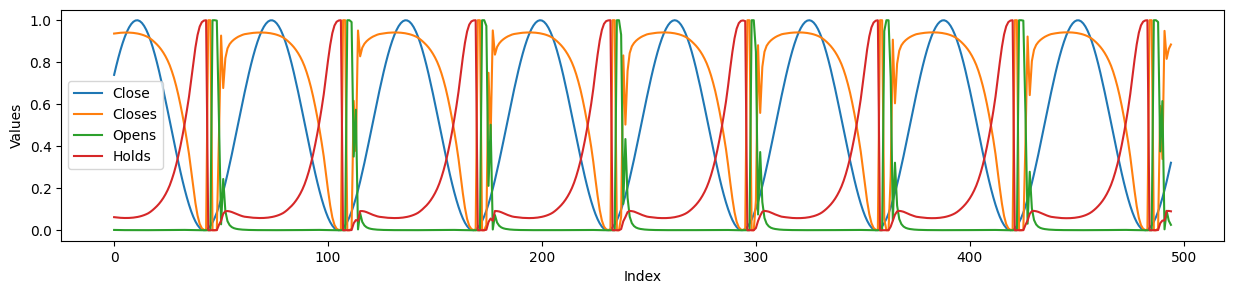

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 3)

# Specify the columns you want to plot from your DataFrame
columns_to_plot = ["Close", "Closes", "Opens", "Holds"]

# Iterate and plot each column
for column in columns_to_plot:
    plt.plot(df_new[column].to_list(), label=column)

plt.xlabel("Index") 
plt.ylabel("Values")
plt.legend()
plt.show()

#### PPO Code adapted from https://www.youtube.com/watch?v=hlv79rcHws0 (Machine Learning with Phil)